In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pydicom
import tensorflow as tf
import skimage

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import CSVLogger

Using TensorFlow backend.


In [5]:
def load_images_from_folder(folder):
    images = []
    for i in range(1,601):
        filename = "Mask ("+str(i)+").tif"
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [6]:
masks = load_images_from_folder("mask")

In [7]:
def load_dicom_images_from_folder(folder):
    images = []
    for i in range(1,601):
        filename = "Image ("+str(i)+").dcm"
        data = pydicom.dcmread(os.path.join(folder,filename))
        img = data.pixel_array
        if img is not None:
            images.append(img)
    return images

In [8]:
images = load_dicom_images_from_folder("images")

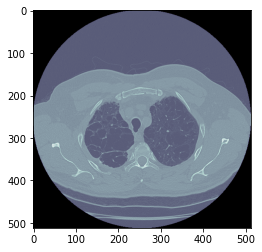

In [9]:
plt.imshow(images[179], cmap=plt.cm.bone)
plt.show()

In [10]:
maskg = []
for i in range(600):    
    maskg.append(cv2.cvtColor(masks[i], cv2.COLOR_BGR2GRAY))

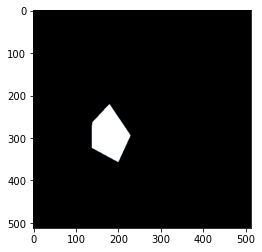

In [11]:
plt.imshow(maskg[179], cmap=plt.cm.bone)
plt.show()

In [12]:
idx = []
count = 0
for i in range(600):
    if(images[i].shape != maskg[i].shape):
        idx.append(i)
        count+=1
print(idx,count)

[] 0


In [13]:
ildimg = []
for i in range(600): 
    if i not in idx:
        ildimg.append(np.multiply(images[i],maskg[i]))

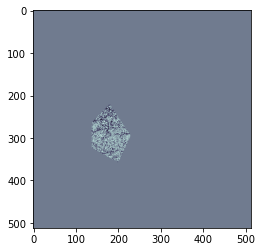

In [14]:
plt.imshow(ildimg[179], cmap=plt.cm.bone)
plt.show()

In [15]:
def crop(img, tol=0):
    mask = img>tol
    m,n = img.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(), n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    cropped = img[row_start:row_end,col_start:col_end]
    #final = img.reshape(cropped,(512,512))
    return cropped

In [16]:
croppi = []
for i in range (600):
    #print(i)
    a = crop(ildimg[i])
    croppi.append(a)
    
croppi = np.asarray(croppi)

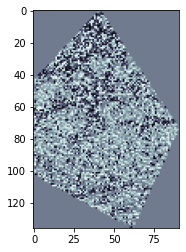

In [17]:
plt.imshow(croppi[179], cmap=plt.cm.bone)
plt.show()

In [18]:
final = []
for i in range(600):
    croppi[i] = np.asarray(croppi[i])
    final.append(cv2.resize(croppi[i],(64,64),interpolation=cv2.INTER_AREA))

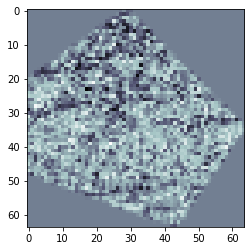

In [19]:
plt.imshow(final[179], cmap=plt.cm.bone)
plt.show()

In [20]:
final = np.asarray(final)
final.shape

(600, 64, 64)

In [21]:
target = []
for i in range(6):
    for j in range(i*100,(i+1)*100):
        target.append(i)
target = np.asarray(target)

In [22]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(final, target, test_size=0.1, random_state=10)
xtrain = np.asarray(xtrain)
ytrain = np.asarray(ytrain)
xtest = np.asarray(xtest)
ytest = np.asarray(ytest)

xtrain = xtrain.reshape(xtrain.shape[0], 256, 256,1)
xtest = xtest.reshape(xtest.shape[0], 256, 256,1)

xtrain = xtrain.astype('float32')
xtest = xtest.astype('float32')
xtrain /= 255
xtest /= 255

from keras.utils import np_utils
ytrain = np_utils.to_categorical(ytrain, 6)
ytest = np_utils.to_categorical(ytest, 6)
ytrain.shape

classifier = Sequential()

classifier.add(Conv2D(filters = 56,kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
classifier.add(MaxPooling2D(pool_size = (2,2)))

classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

classifier.add(Flatten())

classifier.add(Dense(units = 64, activation = 'relu'))

classifier.add(Dense(units = 6 , activation = 'softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy','accuracy'])

classifier.summary()

classifier.fit(xtrain,ytrain, epochs = 1, steps_per_epoch = 3)

In [ ]:
from keras.utils import to_categorical

img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
xtrain = xtrain.reshape(xtrain.shape[0], img_rows, img_cols, 1)
xtrain = xtrain.astype('float32')
xtrain /= 255

# Prepare the test images
xtest = xtest.reshape(xtest.shape[0], img_rows, img_cols, 1)
xtest = xtest.astype('float32')
xtest /= 255


In [ ]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(6, activation='softmax'))

cnn1.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
cnn1.summary()

In [ ]:
cnn1.fit(xtrain,ytrain, epochs = 100, steps_per_epoch = 25)

In [ ]:
xtrain.shape

In [ ]:
score1 = cnn1.evaluate(xtest, ytest, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

In [ ]:
cnn3 = Sequential()
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(6, activation='softmax'))

cnn3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
cnn3.summary()

In [ ]:
cnn3.fit(xtrain,ytrain, epochs = 50, steps_per_epoch = 50)

In [ ]:
score3 = cnn3.evaluate(xtest, ytest, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

In [ ]:
from tensorflow.keras.layers import BatchNormalization

cnn4 = Sequential()
cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.7))

cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.7))

cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.7))

cnn4.add(Flatten())

cnn4.add(Dense(512, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.7))

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.7))

cnn4.add(Dense(6, activation='softmax'))

cnn4.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
cnn4.summary()

In [ ]:
cnn4.fit(xtrain,ytrain, epochs = 50, steps_per_epoch = 50)

In [ ]:
score4 = cnn4.evaluate(xtest, ytest, verbose=0)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

In [ ]:
xtrain2 = []
xtest2 = []
for i in range(540):
    xtrain2.append(cv2.cvtColor(xtrain[i],cv2.COLOR_GRAY2RGB))
    
for i in range(60):
    xtest2.append(cv2.cvtColor(xtest[i],cv2.COLOR_GRAY2RGB))


In [ ]:

import keras
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (64, 64, 3), classes = 6)

# Preprocessing the input 
xtrain2 = np.array(xtrain2)
xtrain2 = preprocess_input(xtrain2.astype(int))
xtest2 = np.array(xtest2)
xtest2 = preprocess_input(xtest2.astype(int))

# Extracting features
train_features = vgg19.predict(np.array(xtrain2))
test_features = vgg19.predict(np.array(xtest2))



In [ ]:
train_features.shape

In [ ]:
# Flatten extracted features
train_features = np.reshape(train_features, (540, 1*1*512))
test_features = np.reshape(test_features, (60, 1*1*512))

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=1 * 1 * 512))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1025, activation='relu'))
model.add(layers.Dropout(0.7))

model.add(layers.Dense(6, activation="softmax"))

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(train_features,ytrain, epochs = 22, steps_per_epoch = 25,validation_data=(test_features, ytest),validation_steps = 10)

In [ ]:
scorevgg = model.evaluate(test_features, ytest, verbose=0)
print('Test loss:', scorevgg[0])
print('Test accuracy:', scorevgg[1])

In [ ]:
#final is the image dataset and target is the y 

In [20]:
flip = []
for i in range(len(final)):
    flip.append(np.fliplr(final[i]))

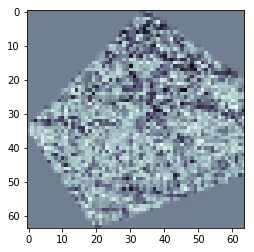

In [21]:
plt.imshow(flip[179], cmap=plt.cm.bone)
plt.show()

In [22]:
plus90 = []
for i in range(len(final)):
    plus90.append(cv2.rotate(final[i], cv2.ROTATE_90_CLOCKWISE))

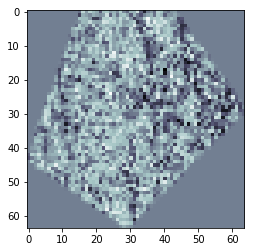

In [27]:
plt.imshow(plus90[179], cmap=plt.cm.bone)
plt.show()

In [23]:
minus90 = []
for i in range(len(final)):
    minus90.append(cv2.rotate(final[i], cv2.ROTATE_90_COUNTERCLOCKWISE))

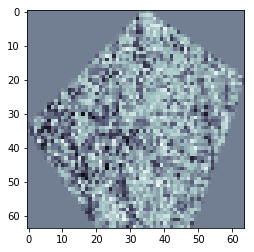

In [28]:
plt.imshow(minus90[179], cmap=plt.cm.bone)
plt.show()

In [24]:
plus180 = []
for i in range(len(final)):
    plus180.append(cv2.rotate(final[i], cv2.ROTATE_180))

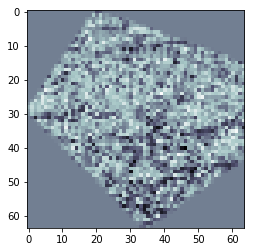

In [29]:
plt.imshow(plus180[179], cmap=plt.cm.bone)
plt.show()

In [25]:
from skimage.transform import rescale
scaled2 = []
for i in range(len(final)):
    scaled2.append(skimage.transform.rescale(final[i], scale=2.0, mode='constant')[32:96,32:96])

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


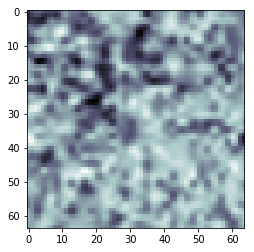

In [30]:
plt.imshow(scaled2[179], cmap=plt.cm.bone)
plt.show()

In [26]:
from skimage.transform import rescale
scaled3 = []
for i in range(len(final)):
    scaled3.append(skimage.transform.rescale(final[i], scale=2.0, mode='constant')[0:64,0:64])

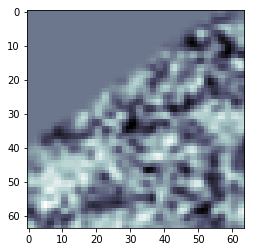

In [32]:
plt.imshow(scaled3[179], cmap=plt.cm.bone)
plt.show()

In [ ]:
scaled3[0]

In [ ]:
aug = []
aug = np.concatenate((final,flip,plus90,minus90,plus180,scaled2,scaled3))

In [ ]:
for i in range(len(aug)):
    aug[i] = ((aug[i]/np.amax(aug[i]))*255).astype('uint8')

In [ ]:
ntarget = []
ntarget = np.concatenate((target,target,target,target,target,target,target))

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
data10 = []
target10 = []
for train_index, test_index in kf.split(aug):
    data10.append(aug[train_index])
    target10.append(ntarget[train_index])

In [ ]:
data10

In [ ]:
cvT = []
cvt = []

tarT = []
tart = []

cvT.append(np.concatenate((data10[0],data10[1],data10[2],data10[3],data10[4],data10[5],data10[6],data10[7],data10[8])))
cvt.append(data10[9])
tarT.append(np.concatenate((target10[0],target10[1],target10[2],target10[3],target10[4],target10[5],target10[6],target10[7],target10[8])))
tart.append(target10[9])

cvT.append(np.concatenate((data10[0],data10[1],data10[2],data10[3],data10[4],data10[5],data10[6],data10[7],data10[9])))
cvt.append(data10[8])
tarT.append(np.concatenate((target10[0],target10[1],target10[2],target10[3],target10[4],target10[5],target10[6],target10[7],target10[9])))
tart.append(target10[8])

cvT.append(np.concatenate((data10[0],data10[1],data10[2],data10[3],data10[4],data10[5],data10[6],data10[8],data10[9])))
cvt.append(data10[7])
tarT.append(np.concatenate((target10[0],target10[1],target10[2],target10[3],target10[4],target10[5],target10[6],target10[8],target10[9])))
tart.append(target10[7])


cvT.append(np.concatenate((data10[0],data10[1],data10[2],data10[3],data10[4],data10[5],data10[7],data10[8],data10[9])))
cvt.append(data10[6])
tarT.append(np.concatenate((target10[0],target10[1],target10[2],target10[3],target10[4],target10[5],target10[7],target10[8],target10[9])))
tart.append(target10[6])

cvT.append(np.concatenate((data10[0],data10[1],data10[2],data10[3],data10[4],data10[6],data10[7],data10[8],data10[9])))
cvt.append(data10[5])
tarT.append(np.concatenate((target10[0],target10[1],target10[2],target10[3],target10[4],target10[6],target10[7],target10[8],target10[9])))
tart.append(target10[5])

cvT.append(np.concatenate((data10[0],data10[1],data10[2],data10[3],data10[5],data10[6],data10[7],data10[8],data10[9])))
cvt.append(data10[4])
tarT.append(np.concatenate((target10[0],target10[1],target10[2],target10[3],target10[5],target10[6],target10[7],target10[8],target10[9])))
tart.append(target10[4])

cvT.append(np.concatenate((data10[0],data10[1],data10[2],data10[4],data10[5],data10[6],data10[7],data10[8],data10[9])))
cvt.append(data10[3])
tarT.append(np.concatenate((target10[0],target10[1],target10[2],target10[4],target10[5],target10[6],target10[7],target10[8],target10[9])))
tart.append(target10[3])

cvT.append(np.concatenate((data10[0],data10[1],data10[3],data10[4],data10[5],data10[6],data10[7],data10[8],data10[9])))
cvt.append(data10[2])
tarT.append(np.concatenate((target10[0],target10[1],target10[3],target10[4],target10[5],target10[6],target10[7],target10[8],target10[9])))
tart.append(target10[2])

cvT.append(np.concatenate((data10[0],data10[2],data10[3],data10[4],data10[5],data10[6],data10[7],data10[8],data10[9])))
cvt.append(data10[1])
tarT.append(np.concatenate((target10[0],target10[2],target10[3],target10[4],target10[5],target10[6],target10[7],target10[8],target10[9])))
tart.append(target10[1])

cvT.append(np.concatenate((data10[1],data10[2],data10[3],data10[4],data10[5],data10[6],data10[7],data10[8],data10[9])))
cvt.append(data10[0])
tarT.append(np.concatenate((target10[1],target10[2],target10[3],target10[4],target10[5],target10[6],target10[7],target10[8],target10[9])))
tart.append(target10[0])

cvT = np.asarray(cvT)
cvt = np.asarray(cvt)

tarT = np.asarray(tarT)
tart = np.asarray(tart)

In [ ]:
from keras.utils import to_categorical

img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
for i in range(10):
    cvT[i] = cvT[i].reshape(3780, img_rows, img_cols, 1)
    cvT[i] = cvT[i].astype('float32')
    cvt[i] = cvt[i].reshape(420, img_rows, img_cols, 1)
    cvt[i] = cvt[i].astype('float32'
#xtrain /= 255

# Prepare the test images
)
#xtest /= 255

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(aug, ntarget, test_size=0.1, random_state=10)
xtrain = np.asarray(xtrain)
ytrain = np.asarray(ytrain)
xtest = np.asarray(xtest)
ytest = np.asarray(ytest)

In [ ]:
from keras.utils import to_categorical

img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
xtrain = xtrain.reshape(xtrain.shape[0], img_rows, img_cols, 1)
xtrain = xtrain.astype('float32')
#xtrain /= 255

# Prepare the test images
xtest = xtest.reshape(xtest.shape[0], img_rows, img_cols, 1)
xtest = xtest.astype('float32')
#xtest /= 255

In [ ]:
xtrain[0].shape

import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
dataT = []
datat = []
targetT = []
targett = []
for train_index, test_index in kf.split(xtrain):
    dataT.append(xtrain[train_index])
    targetT.append(ytrain[train_index])
    datat.append(xtest[test_index])
    targett.append(ytest[test_index])

In [ ]:
targett

In [ ]:
xtrain2 = []
xtest2 = []
for i in range(3780):
    print(i)
    xtrain2.append(cv2.cvtColor(xtrain[i],cv2.COLOR_GRAY2RGB))
    
for i in range(420):
    xtest2.append(cv2.cvtColor(xtest[i],cv2.COLOR_GRAY2RGB))

In [ ]:

import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (64, 64, 3), classes = 6)

# Preprocessing the input 
xtrain2 = np.array(xtrain2)
xtrain2 = preprocess_input(xtrain2.astype(int))
xtest2 = np.array(xtest2)
xtest2 = preprocess_input(xtest2.astype(int))

# Extracting features
train_features = vgg19.predict(np.array(xtrain2))
test_features = vgg19.predict(np.array(xtest2))

In [ ]:
# Flatten extracted features
train_features = np.reshape(train_features, (3780, 1*1*512))
test_features = np.reshape(test_features, (420, 1*1*512))

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=1 * 1 * 512))

model.add(layers.Dense(1025, activation='relu'))

model.add(layers.Dense(2051, activation='relu'))

model.add(layers.Dense(1025, activation='relu'))

model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(6, activation="softmax"))

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(train_features,ytrain, epochs = 50, steps_per_epoch = 50,validation_data=(test_features, ytest),validation_steps = 10)

In [ ]:
scorevgg = model.evaluate(test_features, ytest, verbose=0)
print('Test loss:', scorevgg[0])
print('Test accuracy:', scorevgg[1])

In [ ]:
from tensorflow.python.keras.layers import BatchNormalization

cnn4 = Sequential()
cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(64,64,1)))
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.55))

cnn4.add(Conv2D(257, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.55))

cnn4.add(Conv2D(515, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())

cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.5))

cnn4.add(Flatten())

cnn4.add(Dense(1031, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.65))

cnn4.add(Dense(257, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.55))

cnn4.add(Dense(6, activation='softmax'))

cnn4.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
cnn4.summary()

In [ ]:
for i in range(10):
    print('SET 1')
    cnn4.fit(cvT[i],tarT[i], epochs = 100, steps_per_epoch = 30,validation_data=(cvt[i], tart[i]),validation_steps = 30)
    score4 = cnn4.evaluate(cvt[i], tart[i], verbose=0)
    print('Test loss:', score4[0])
    print('Test accuracy:', score4[1])